# Basic Simulation of Denoising Methodologies

In this notebook we compare three empirical Bayes denoising methods on a simulated data set, and we create Figure 1.1 from the arxiv version of the paper.

In [1]:
# import packages

from npeb.GLMixture import *
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import itertools
import scipy.stats as stats
from scipy.linalg import sqrtm, inv
from scipy.spatial import distance_matrix

## Set up data

We sample the latent variables $\Theta_1,\ldots,\Theta_n$ from a distribution $G$ which is two-component Gaussian mixture model in $\mathbb{R}^2$, with component centers $c_1 = (0.5, 0.5)^{\top}$ and $c_2 = (-0.5, -0.5)^{\top}$ and component variance $\tau^2I_2$ for $\tau^2 = 0.1$. Then, we sample the observations from a Gaussian likelihood with variance $\sigma^2I_2$ for $\sigma^2 = 0.1$.

In [2]:
# set parameters

n = 2500
center1 = np.asarray([0.5, 0.5])
center2 = np.asarray([-0.5, -0.5])
tau2 = 0.1
sigma2 = 1.0

np.random.seed(54321)

In [3]:
# function for sampling the latent variables

centers = np.vstack([center1,center2])

def sample_latent(nsamples,var):
    classes = np.random.randint(0,2,size=nsamples)
    indices = np.zeros((nsamples,2))
    indices[np.arange(nsamples),classes] = 1
    Theta = np.random.normal(indices@centers,np.sqrt(var))
    return Theta

In [4]:
# sample the latent variables and the observations

Theta =  sample_latent(n,tau2)
prec = np.ones_like(Theta)/sigma2
prec_smooth = 1./(1./prec + tau2)
Z = np.random.normal(Theta,np.sqrt(sigma2),size=(n,2))
L = np.max(Z)

## Compute denoisers

Next, we compute the three denoisers of interest (at both the oracle and empirical levels) for the data above. We do this with the help of the `npeb` package above.

### (Unconstrained) oracle Bayes

In [5]:
ob_model = GLMixture(prec_type='diagonal')
n_supp = 10000
supp = sample_latent(n_supp,tau2)
ob_model.set_params(atoms=supp, weights=np.ones(n_supp)/n_supp)
ob = ob_model.posterior_mean(Z, prec)

### (Unconstrained) empirical Bayes

In [6]:
eb_model = GLMixture(prec_type='diagonal')
eb_model.fit(Z, prec)

eb_post_means = eb_model.posterior_mean(Z, 1./(1./prec + tau2))
eb = tau2 * Z / (tau2 + 1./prec) + (1./prec) * eb_post_means / (tau2 + 1./prec)

Selecting all data points as atoms: done.
Computing kernel matrix: done.
Solving for discretized NPMLE: done.


### Oracle variance-constrained Bayes

In [7]:
M = np.cov(ob.T)
A = np.cov(Theta.T)
transport = inv(sqrtm(M))@sqrtm(sqrtm(M)@A@sqrtm(M))@inv(sqrtm(M))
ovcb = ob@transport

### Empirical variance-constrained Bayes

In [8]:
c = np.mean(eb,axis=0)
M_hat = (eb-c).T@(eb-c)/n

mu_hat = np.mean(Z,axis=0)
A_hat = (Z-mu_hat).T@(Z-mu_hat)/n - sigma2*np.eye(2)

transport_hat = inv(sqrtm(M_hat))@sqrtm(sqrtm(M_hat)@A_hat@sqrtm(M_hat))@inv(sqrtm(M_hat))

evcb = (eb - mu_hat)@transport_hat + mu_hat

### Oracle distribution-constrained Bayes

In [9]:
k = 200  # grid resolution
K = 1500 # subsampling

Eta_univ = np.linspace(-1.5,1.5,k)
Eta = np.array(list(itertools.product(Eta_univ,Eta_univ)))

Eta_wt = np.zeros(k**2)
for i in range(n):
    rv = stats.multivariate_normal(mean=Theta[i,:], cov=np.asarray([[tau2, 0], [0, tau2]]))
    probs = rv.pdf(Eta)
    Eta_wt += probs / (np.sum(probs) * n)

inds = np.random.choice(np.arange(k**2), size=K, replace=False, p=Eta_wt)
Eta = Eta[inds]
Eta_wt = Eta_wt[inds]/np.sum(Eta_wt[inds])

In [10]:
pi = cp.Variable((n,K))
C = distance_matrix(ob, Eta)**2
objv = cp.Minimize(cp.sum(cp.multiply(C, pi)))
cstr = [pi >= 0, cp.sum(pi) == 1.,
        cp.sum(pi, axis=1) == np.ones(n)/n,
        cp.sum(pi, axis=0) == Eta_wt]

problem = cp.Problem(objv,cstr)
problem.solve(solver='MOSEK',verbose=False)
pi_opt = pi.value
odcb = np.zeros((n,2))
for i in range(n):
    odcb[i,:] = (pi_opt[i,:].reshape(1,-1)@Eta)/np.sum(pi_opt[i,:])

### Empirical distribution-constrained Bayes

In [11]:
at, wt = eb_model.get_params()
Eta_univ = np.linspace(-1.5,1.5,k)
Eta = np.array(list(itertools.product(Eta_univ,Eta_univ)))
Eta = np.vstack([Eta, at])
m = len(wt)

Eta_wt = np.zeros(k**2 + m)
for i in range(m):
    rv = stats.multivariate_normal(mean=at[i,:], cov=np.asarray([[tau2, 0], [0, tau2]]))
    probs = rv.pdf(Eta)
    Eta_wt += probs * wt[i] / np.sum(probs)

inds = np.random.choice(np.arange(k**2 + m), size=K, replace=False, p=Eta_wt)
Eta = Eta[inds]
Eta_wt = Eta_wt[inds]/np.sum(Eta_wt[inds])

In [12]:
pi = cp.Variable((n,K))
C_hat = distance_matrix(eb, Eta)**2
objv = cp.Minimize(cp.sum(cp.multiply(C_hat, pi)))
cstr = [pi >= 0, cp.sum(pi) == 1.,
        cp.sum(pi, axis=1) == np.ones(n)/n,
        cp.sum(pi, axis=0) == Eta_wt]

problem = cp.Problem(objv,cstr)
problem.solve(solver='MOSEK',verbose=False)
pi_opt = pi.value
edcb = np.zeros((n,2))
for i in range(n):
    edcb[i,:] = (pi_opt[i,:].reshape(1,-1)@Eta)/np.sum(pi_opt[i,:])

## Plotting

Lastly, we plot the latent variables and the observations, along with the three denoising methods of interest, at both the oracle and empirical levels.

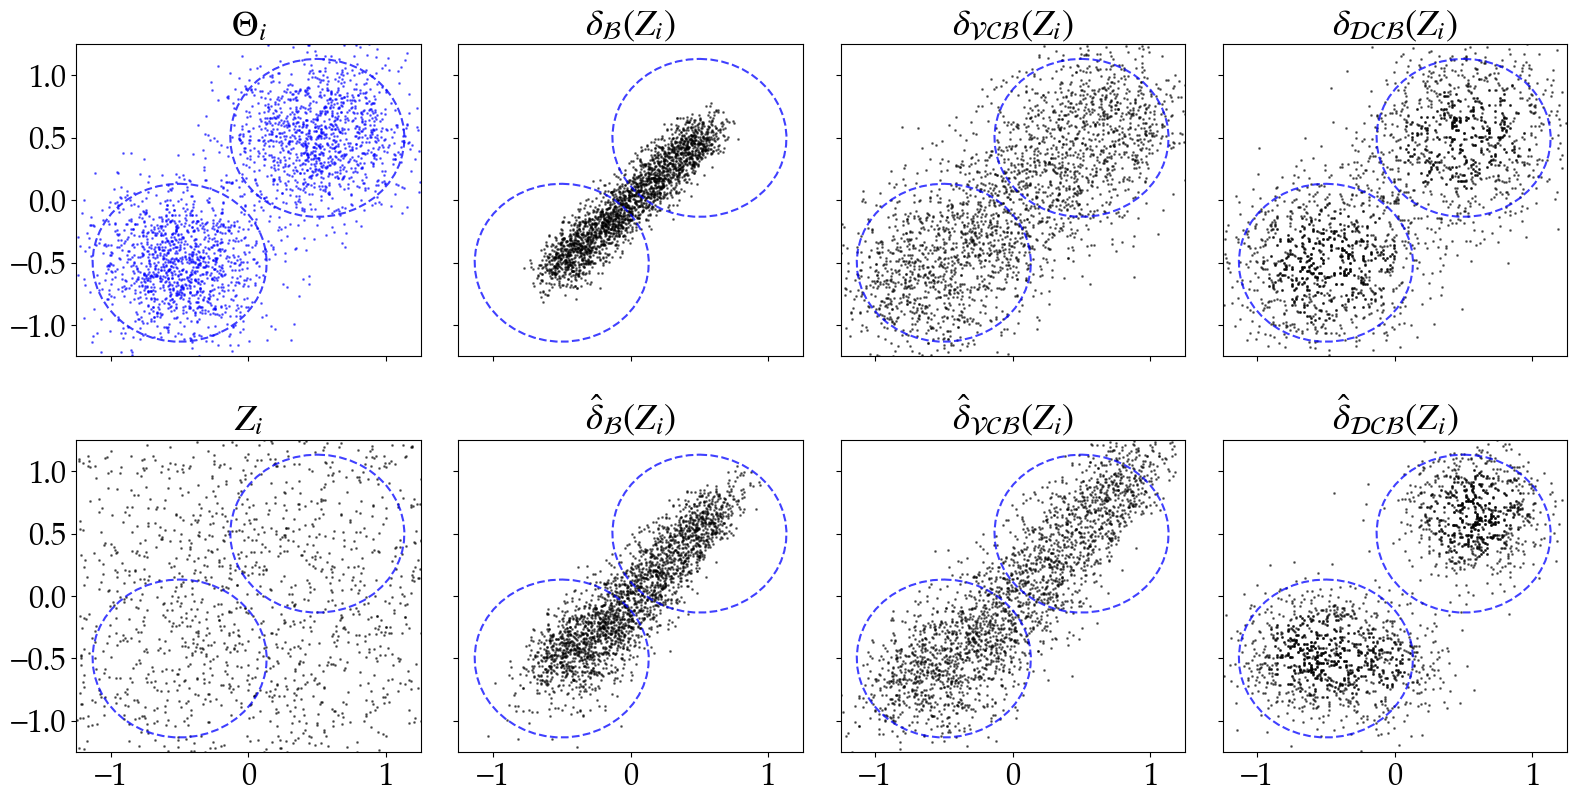

In [14]:
plt.rcParams.update({'font.size': 22,
                     'mathtext.fontset': 'stix',
                     'font.family': 'serif',
                     'font.serif':'Palatino'})

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(16,8.5))
Z_alpha = 0.5
Z_s = 1.0
G_alpha = 0.5

# top row

ax[0,0].set_title('$\\Theta_i$')
ax[0,0].scatter(Theta[:,0], Theta[:,1], s=Z_s,color='blue', alpha=Z_alpha)
    
ax[0,1].set_title('$\\delta_{\\mathcal{B}}(Z_i)$')
ax[0,1].scatter(ob[:,0], ob[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[0,2].set_title('$\\delta_{\\mathcal{VCB}}(Z_i)$')
ax[0,2].scatter(ovcb[:,0], ovcb[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[0,3].set_title('$\\delta_{\\mathcal{DCB}}(Z_i)$')
ax[0,3].scatter(odcb[:,0], odcb[:,1], s=Z_s,color='black', alpha=Z_alpha)

# bottom row

ax[1,0].set_title('$Z_i$')
ax[1,0].scatter(Z[:,0], Z[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[1,1].set_title('$\\hat{\\delta}_{\\mathcal{B}}(Z_i)$')
ax[1,1].scatter(eb[:,0], eb[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[1,2].set_title('$\\hat{\\delta}_{\\mathcal{VCB}}(Z_i)$')
ax[1,2].scatter(evcb[:,0], evcb[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[1,3].set_title('$\\hat{\\delta}_{\\mathcal{DCB}}(Z_i)$')
ax[1,3].scatter(edcb[:,0], edcb[:,1], s=Z_s,color='black', alpha=Z_alpha)

u = np.linspace(0,2*np.pi)
circ1 = center1 + 2*np.sqrt(tau2)*np.vstack([np.sin(u),np.cos(u)]).T
circ2 = center2 + 2*np.sqrt(tau2)*np.vstack([np.sin(u),np.cos(u)]).T
for i in range(2):
    for j in range(4):
        # if i > 0 or j > 0:
        ax[i,j].plot(circ1[:,0],circ1[:,1],color='blue',linestyle='dashed', alpha=0.75)
        ax[i,j].plot(circ2[:,0],circ2[:,1],color='blue',linestyle='dashed', alpha=0.75)
            # ax[i,j].scatter(Theta[:,0], Theta[:,1], s=Z_s,color='blue', alpha=G_alpha)

plt.xlim([-1.25,1.25])
plt.ylim([-1.25, 1.25])
plt.tight_layout()
plt.savefig('BasicSimulation.pdf')
plt.savefig('BasicSimulation.png')